In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate, name):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            cell = tf.nn.rnn_cell.LSTMCell(layer_size, state_is_tuple = False)
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * layer_size))
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            self.logits = tf.layers.dense(self.rnn[:,-1], output_size)
            self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 1
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                           'real_model')
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                                   'negative_model')
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.model.logits, feed_dict={self.model.X:states, 
                                                   self.model.hidden_layer:init_values})
        Q_new = self.sess.run(self.model.logits, feed_dict={self.model.X:new_states, 
                                                       self.model.hidden_layer:init_values})
        Q_new_negative = self.sess.run(self.model_negative.logits, 
                                  feed_dict={self.model_negative.X:new_states, 
                                             self.model_negative.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.model.logits,self.model.last_state],
                                                feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                            self.model.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('real_model', 'negative_model')
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.model.logits,
                                                  self.model.last_state],
                                                  feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                             self.model.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y,
                                                  self.model.hidden_layer: INIT_VAL})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1974.699953.3, cost: 0.137796, total money: 6090.179933
epoch: 20, total rewards: 655.724851.3, cost: 0.169749, total money: 10655.724851
epoch: 30, total rewards: 711.205263.3, cost: 0.486208, total money: 2767.685243
epoch: 40, total rewards: 1176.789923.3, cost: 0.651744, total money: 11176.789923
epoch: 50, total rewards: 684.334290.3, cost: 0.617753, total money: 2834.784241
epoch: 60, total rewards: 285.165347.3, cost: 1.174647, total money: 2411.925355
epoch: 70, total rewards: 681.124756.3, cost: 0.186755, total money: 10681.124756
epoch: 80, total rewards: 870.010131.3, cost: 1.523407, total money: 1363.290220
epoch: 90, total rewards: 656.920166.3, cost: 0.451867, total money: 8669.740173
epoch: 100, total rewards: 305.970214.3, cost: 0.180303, total money: 9286.700194
epoch: 110, total rewards: 706.894774.3, cost: 0.206065, total money: 5791.824766
epoch: 120, total rewards: 737.390079.3, cost: 1.029069, total money: 4082.000004
epoch: 130, total re

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 785.309998, total balance 9214.690002
day 6, sell 1 unit at price 762.559998, investment -2.896945 %, total balance 9977.250000,
day 9: buy 1 unit at price 758.489990, total balance 9218.760010
day 10: buy 1 unit at price 764.479980, total balance 8454.280030
day 11: buy 1 unit at price 771.229980, total balance 7683.050050
day 12: buy 1 unit at price 760.539978, total balance 6922.510072
day 14, sell 1 unit at price 768.270020, investment 1.289408 %, total balance 7690.780092,
day 16: buy 1 unit at price 761.679993, total balance 6929.100099
day 17, sell 1 unit at price 768.239990, investment 0.491839 %, total balance 7697.340089,
day 18, sell 1 unit at price 770.840027, investment -0.050562 %, total balance 8468.180116,
day 19, sell 1 unit at price 758.039978, investment -0.328714 %, total balance 9226.220094,
day 20: buy 1 unit at price 747.919983, total balance 8478.300111
day 25, sell 1 unit at price 776.419983, investment 1.935195 %, total balance 9254.

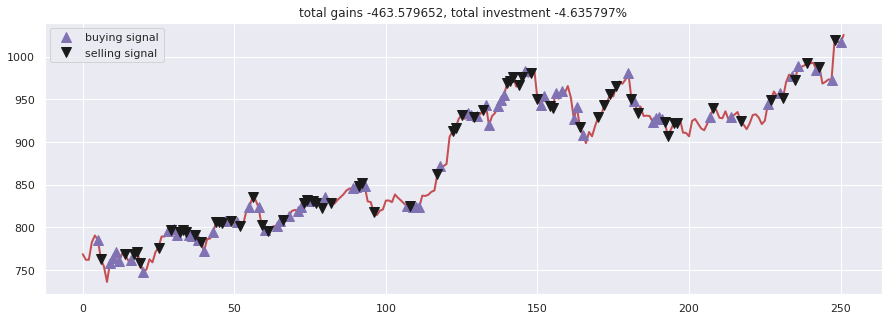

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()